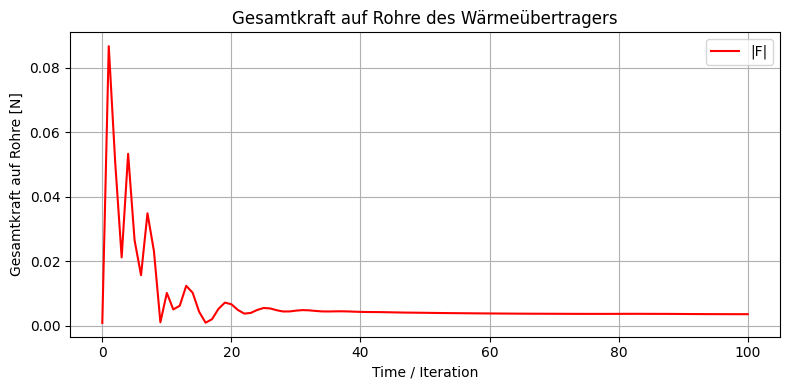

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re

file = "wärmeübertrager/postProcessing/forcesPipe/0/forces.dat"

times = []
Fx = []
Fy = []
Fz = []

pattern = re.compile(r"\(\((.*?)\)\s+\((.*?)\)\)")  # matches: ((pressure) (viscous))

with open(file) as f:
    for line in f:
        if line.startswith("#"):
            continue

        parts = line.split()
        t = float(parts[0])          # time

        # Extract the two force vectors via regex
        matches = pattern.findall(line)
        if not matches:
            continue

        # First match → forces block: (pressureVec) (viscousVec)
        pressure_str, viscous_str = matches[0]

        px, py, pz = map(float, pressure_str.split())
        vx, vy, vz = map(float, viscous_str.split())

        Fx.append(px + vx)
        Fy.append(py + vy)
        Fz.append(pz + vz)
        times.append(t)

F = np.sqrt(np.array(Fx)**2 + np.array(Fy)**2 + np.array(Fz)**2)
# Plot
plt.figure(figsize=(8,4))
plt.plot(times, F, label="|F|", linestyle='-', color='r')
plt.title("Gesamtkraft auf Rohre des Wärmeübertragers")
plt.xlabel("Time / Iteration")
plt.ylabel("Gesamtkraft auf Rohre [N]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("img/aufgabe3_maxForce.png", dpi=160)


